## 1. Постановка задачи

  
Необходимо решить задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import xgboost as xgb

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression

sns.set_palette("tab10")

Прочитаем наш файл с исходными данными:

In [17]:
taxi_data = pd.read_csv("Data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [18]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print('Дата и время первой записи в базе:', taxi_data['pickup_datetime'].min())
print('Дата и время последней записи в базе:', taxi_data['pickup_datetime'].max())

Дата и время первой записи в базе: 2016-01-01 00:00:17
Дата и время последней записи в базе: 2016-06-30 23:59:39


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [19]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [20]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [21]:
print('Количество уникальных таксопарков:', taxi_data['vendor_id'].nunique())
print('Максимальное количество пассажиров:', taxi_data['passenger_count'].max())
print('Средняя длительность поездки:', round(taxi_data['trip_duration'].mean()))
print('Медианная длительность поездки:', round(taxi_data['trip_duration'].median()))
print('Минимальное время поездки:', taxi_data['trip_duration'].min())
print('Максимальное время поездки:', taxi_data['trip_duration'].max())
taxi_data['trip_duration'].describe()

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность поездки: 959
Медианная длительность поездки: 662
Минимальное время поездки: 1
Максимальное время поездки: 3526282


count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы.

→ При дальнейшем анализе выяснится, что у нас также есть «телепортации» — поездки, которые были проделаны за секунды на большие расстояния. Но всему своё время.

Чтобы однозначно обозначить такие записи в таблице как выбросы, нам необходимо произвести более глубокий анализ данных с подключением дополнительной информации.

Примечание. На основе полученной статистической информации о целевом признаке trip_duration мы также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как усечённое среднее, логарифмическое среднее или медиана. При проведении исследований мы будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Примечание. Так как все манипуляции над данными мы будем применять как с тренировочным, так и с тестовым набором данных, во избежание дублирования кода мы будем производить предобработку с помощью функций. Также применение функций позволит нам сделать код гораздо более эстетичным и читабельным, что будет плюсом при просмотре вашего проекта потенциальным работодателем.

Начнём с временных характеристик. Как нам уже известно, хранить дату и время в формате datetime как категориальный признак редко имеет смысл, поэтому их разбивают на отдельные признаки. Эти признаки могут как стать основными факторами при построении модели, так и быть вспомогательными для извлечения информации из других таблиц.

### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [22]:
def add_datetime_features(data, data_col):
    # data_col = data.select_dtypes('<M8[ns]').columns
    data['pickup_date'] = data[data_col].dt.date
    data['pickup_hour'] = data[data_col].dt.hour
    data['pickup_day_of_week'] = data[data_col].dt.weekday
    return data

In [23]:
add_datetime_features(taxi_data, 'pickup_datetime')
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5


In [24]:
print('Количество поездок в субботу =', taxi_data[taxi_data['pickup_day_of_week']==5]['pickup_day_of_week'].count())

Количество поездок в субботу = 220868


In [25]:
print('Количество поезодк в среднем за день = ', round(taxi_data.groupby('pickup_date')['id'].count().mean()))

Количество поезодк в среднем за день =  8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [26]:
holiday_data = pd.read_csv('Data/holiday_data.csv', sep=';')

In [27]:
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%Y-%m-%d').dt.date
holiday_data.info()
holiday_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   day      14 non-null     object
 1   date     14 non-null     object
 2   holiday  14 non-null     object
dtypes: object(3)
memory usage: 464.0+ bytes


,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


In [28]:
def add_holiday_features(data, holiday_data):
    data['pickup_holiday'] = data['pickup_date'].isin(holiday_data['date']).astype('int')
    return data

In [29]:
add_holiday_features(taxi_data, holiday_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0


In [30]:
print('Медианная длительность поездки на такси в праздничные дни = {:.0f} секунд'.format((taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median())))

Медианная длительность поездки на такси в праздничные дни = 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [31]:
osrm_data = pd.read_csv('Data/osrm_data_train.csv')

In [32]:
def add_osrm_features(data, osrm_data):
    osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    data = pd.merge(data, osrm_data, on='id', how='left')
    return data

In [33]:
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0


In [34]:
print('Разница в секундах между медианной длительностью поездки в данных \nи медианной длительностью поездки, полученной из OSRM =',
      round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()))

Разница в секундах между медианной длительностью поездки в данных 
и медианной длительностью поездки, полученной из OSRM = 372


In [35]:
taxi_data.isnull().sum()
taxi_data[taxi_data.isnull().any(axis=1)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


Введём в наш анализ расстояние по формуле гаверсинуса. 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.


In [36]:
# функция для вычисления расстояния по формуле гаверсинуса (в километрах)
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# функция для вычисления угла направления движения (в градусах)
def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [37]:
def add_geographical_features(data):
    lat1 = data['pickup_latitude']
    lng1 = data['pickup_longitude']
    lat2 = data['dropoff_latitude']
    lng2 = data['dropoff_longitude']
    data['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    data['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return data

taxi_data = add_geographical_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585


In [38]:
print('Медианное расстояние по формуле гаверсинуса для поездок (в километрах) = ', round(taxi_data['haversine_distance'].median(), 2))

Медианное расстояние по формуле гаверсинуса для поездок (в километрах) =  2.09


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [39]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(data, model):
    trip_coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                             data[['dropoff_latitude', 'dropoff_longitude']]))
    data['geo_cluster'] = model.predict(trip_coords)
    return data

taxi_data = add_cluster_features(taxi_data, kmeans)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165,6
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700,6
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585,0


In [40]:
# Смотрим сколько поездок в наименьшем по размеру географическом кластере
taxi_data['id'].groupby(taxi_data['geo_cluster']).count().sort_values()

geo_cluster
2         2
3         4
9        18
7     15355
5     32799
4     40234
8     45518
6    340489
0    392108
1    592117
Name: id, dtype: int64

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [41]:
weather_data = pd.read_csv('Data/weather_data.csv')

weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8787 non-null   object 
 1   temperature  8787 non-null   float64
 2   windchill    2295 non-null   float64
 3   heat index   815 non-null    float64
 4   humidity     8787 non-null   float64
 5   pressure     8556 non-null   float64
 6   dew Point    8787 non-null   float64
 7   visibility   8787 non-null   float64
 8   wind dir     8787 non-null   object 
 9   wind speed   8787 non-null   float64
 10  gust speed   8787 non-null   float64
 11  precip       8787 non-null   float64
 12  events       8787 non-null   object 
 13  conditions   8787 non-null   object 
 14  date         8787 non-null   object 
 15  hour         8787 non-null   int64  
dtypes: float64(10), int64(1), object(5)
memory usage: 1.1+ MB


In [42]:
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%Y-%m-%d').dt.date

def add_weather_features(data, weather_data):
    weather_data = weather_data[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']]
    data = pd.merge(data, weather_data, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    data.drop(['date', 'hour'], axis=1, inplace=True)
    return data

taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()
    

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None


In [43]:
# Выводим уникальные значения для погодных явлений
weather_data['events'].unique()

array(['None', 'Rain', 'Snow', 'Fog'], dtype=object)

In [44]:
print('Количество поездок в снежную погоду=', taxi_data[taxi_data['events'] == 'Snow']['id'].count())

Количество поездок в снежную погоду= 13126


In [45]:
# Расчет процентов пропусков в столбцах
cols_null_percent = taxi_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null.round(2))

temperature          0.82
visibility           0.82
wind speed           0.82
precip               0.82
events               0.82
total_distance       0.00
total_travel_time    0.00
number_of_steps      0.00
dtype: float64

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [46]:
def fill_null_weather_data(data):
    col = ['temperature', 'visibility', 'wind speed', 'precip']
    data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))
    
    data.events.fillna('None', inplace=True)
    
    cols_osrm = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in cols_osrm:
        taxi_data[col].fillna(taxi_data[col].median(), inplace=True)
        
    return data
    

In [47]:
taxi_data = fill_null_weather_data(taxi_data)
print('Медиана в столбце temperature после заполнения пропусков = {:.1f}'.format(taxi_data['temperature'].median()))

Медиана в столбце temperature после заполнения пропусков = 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


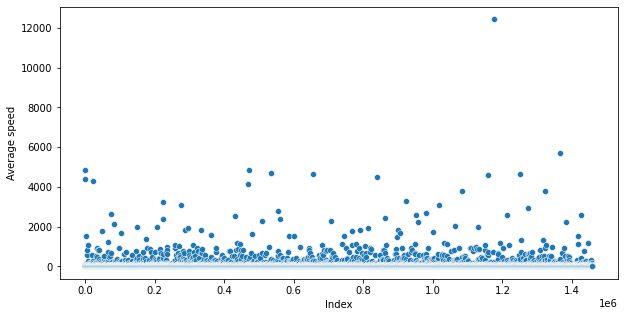

In [48]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [49]:
# Находим поездки, длительность которых превышает 24 часа
mask = taxi_data['trip_duration'] >= 24 * 3600
print('Количество выбросов по длительности поездки =', taxi_data[mask].shape[0])
# Удаляем эти поездки
taxi_data.drop(taxi_data[mask].index, axis=0, inplace=True)
taxi_data.shape

Количество выбросов по длительности поездки = 4


(1458640, 26)

In [50]:
# Находим поездки, средня скорость которых больше 300 км/ч
mask_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 >= 300
print('Количество выбросов по скорости =', taxi_data[mask_speed].shape[0])
# Удаляем эти поездки
taxi_data.drop(taxi_data[mask_speed].index, axis=0, inplace=True)
taxi_data.shape

Количество выбросов по скорости = 407


(1458233, 26)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [51]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

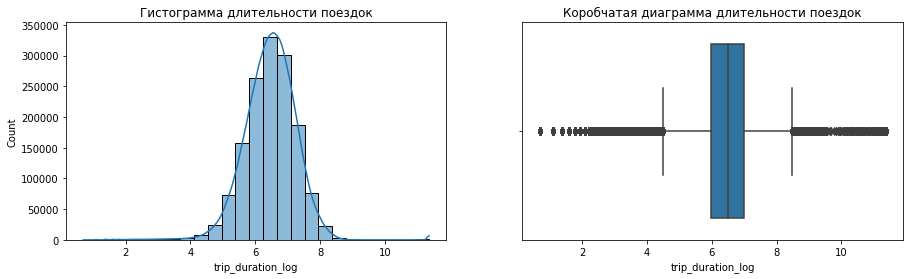

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
hist_data = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    ax=axes[0]
)
hist_data.set_title('Гистограмма длительности поездок')

boxplot_duration = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    orient='h',
    width=0.8,
    ax=axes[1]
)
boxplot_duration.set_title('Коробчатая диаграмма длительности поездок');

In [53]:
# Задаем уровень значимости
alpha = 0.05

# Проводим тест Шапиро-Уилка
_, p_value = stats.normaltest(taxi_data.trip_duration_log)

print('P-value = %.2f' %(p_value))
# print('P-value = {:.3f}'.format(p_value))

# Интерпретируем результат
if p_value <= alpha:
    print('Рапределение не нормальное')
else:
    print('Распределение нормальное')

P-value = 0.00
Рапределение не нормальное


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

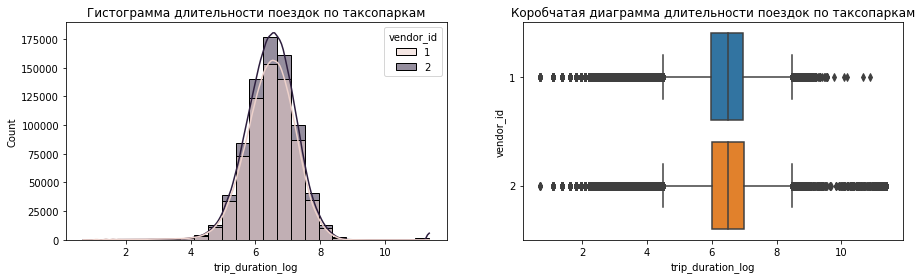

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
hist_data = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    hue='vendor_id',
    bins=25,
    kde=True,    
    ax=axes[0]
)
hist_data.set_title('Гистограмма длительности поездок по таксопаркам')

boxplot_duration = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='vendor_id',
    orient='h',
    width=0.8,
    ax=axes[1]
)
boxplot_duration.set_title('Коробчатая диаграмма длительности поездок по таксопаркам');

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

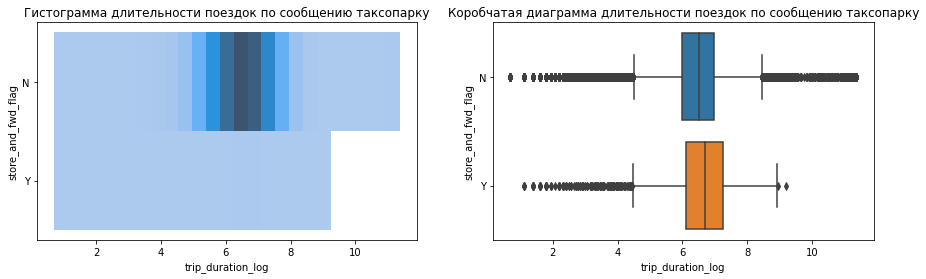

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
hist_data = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    bins=25,
    kde=True,
    ax=axes[0]
)
hist_data.set_title('Гистограмма длительности поездок по сообщению таксопарку')

boxplot_duration = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    orient='h',
    width=0.8,
    ax=axes[1]
)
boxplot_duration.set_title('Коробчатая диаграмма длительности поездок по сообщению таксопарку');

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [56]:
hour_group_data = taxi_data.groupby('pickup_hour', as_index=False)['trip_duration'].count()
hour_group_data['median_duration'] = taxi_data.groupby('pickup_hour')['trip_duration'].median()
hour_group_data.rename(columns={'trip_duration': 'trip_count'}, inplace=True)
hour_group_data

,pickup_hour,trip_count,median_duration
0,0,53234,646.0
1,1,38562,614.0
2,2,27966,591.0
3,3,20888,592.0
4,4,15784,611.0
5,5,14990,518.0
6,6,33233,473.0
7,7,55580,575.0
8,8,67040,661.0
9,9,67646,681.0


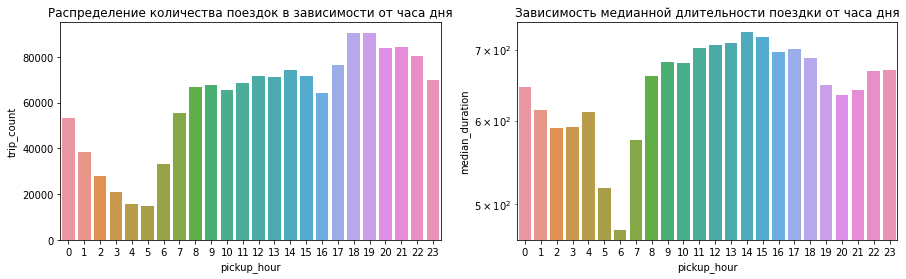

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
bar_data = sns.barplot(
    data=hour_group_data,
    x='pickup_hour',
    y='trip_count',    
    ax=axes[0]
)
bar_data.set_title('Распределение количества поездок в зависимости от часа дня')

bar_median_duration = sns.barplot(
    data=hour_group_data,
    x=hour_group_data['pickup_hour'],
    y=hour_group_data['median_duration'],    
    ax=axes[1]    
)
bar_median_duration.set_title('Зависимость медианной длительности поездки от часа дня');
plt.yscale('log')

- Реже всего заказывают такси с 2 до 5 утра
- Пик медианной длительности поездок наблюдается в 13-15 часов

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


In [58]:
day_group_data = taxi_data.groupby('pickup_day_of_week', as_index=False)['trip_duration'].count()
day_group_data['median_duration'] = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
day_group_data.rename(columns={'trip_duration': 'trip_count'}, inplace=True)
day_group_data

,pickup_day_of_week,trip_count,median_duration
0,0,187357,630.0
1,1,202696,679.0
2,2,210094,694.0
3,3,218497,710.0
4,4,223484,686.0
5,5,220805,637.0
6,6,195300,602.0


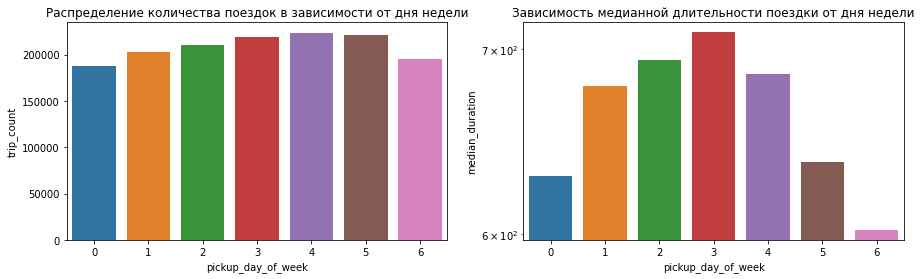

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
bar_data = sns.barplot(
    data=day_group_data,
    x='pickup_day_of_week',
    y='trip_count',    
    ax=axes[0]
)
bar_data.set_title('Распределение количества поездок в зависимости от дня недели')

bar_median_duration = sns.barplot(
    data=day_group_data,
    x='pickup_day_of_week',
    y='median_duration',    
    ax=axes[1]    
)
bar_median_duration.set_title('Зависимость медианной длительности поездки от дня недели');
plt.yscale('log')

- больше всего поездок совершается в пятницу
- наименьшая медианная длительность поезодк - в воскресенье

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [60]:
pivot_data = pd.pivot_table(taxi_data, 
                            columns='pickup_hour',
                            index='pickup_day_of_week',
                            values='trip_duration',
                            aggfunc='median'
                            )

fig = px.imshow(    
    pivot_data,
    color_continuous_scale='Jet',
    labels=dict(x='Час дня', y='День недели'),
    title='Тепловая карта зависимости медианной длительности поездки от дня недели и времени дня',  
)

fig.show()

- Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.
- Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


c:\Users\Alexey\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

c:\Users\Alexey\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



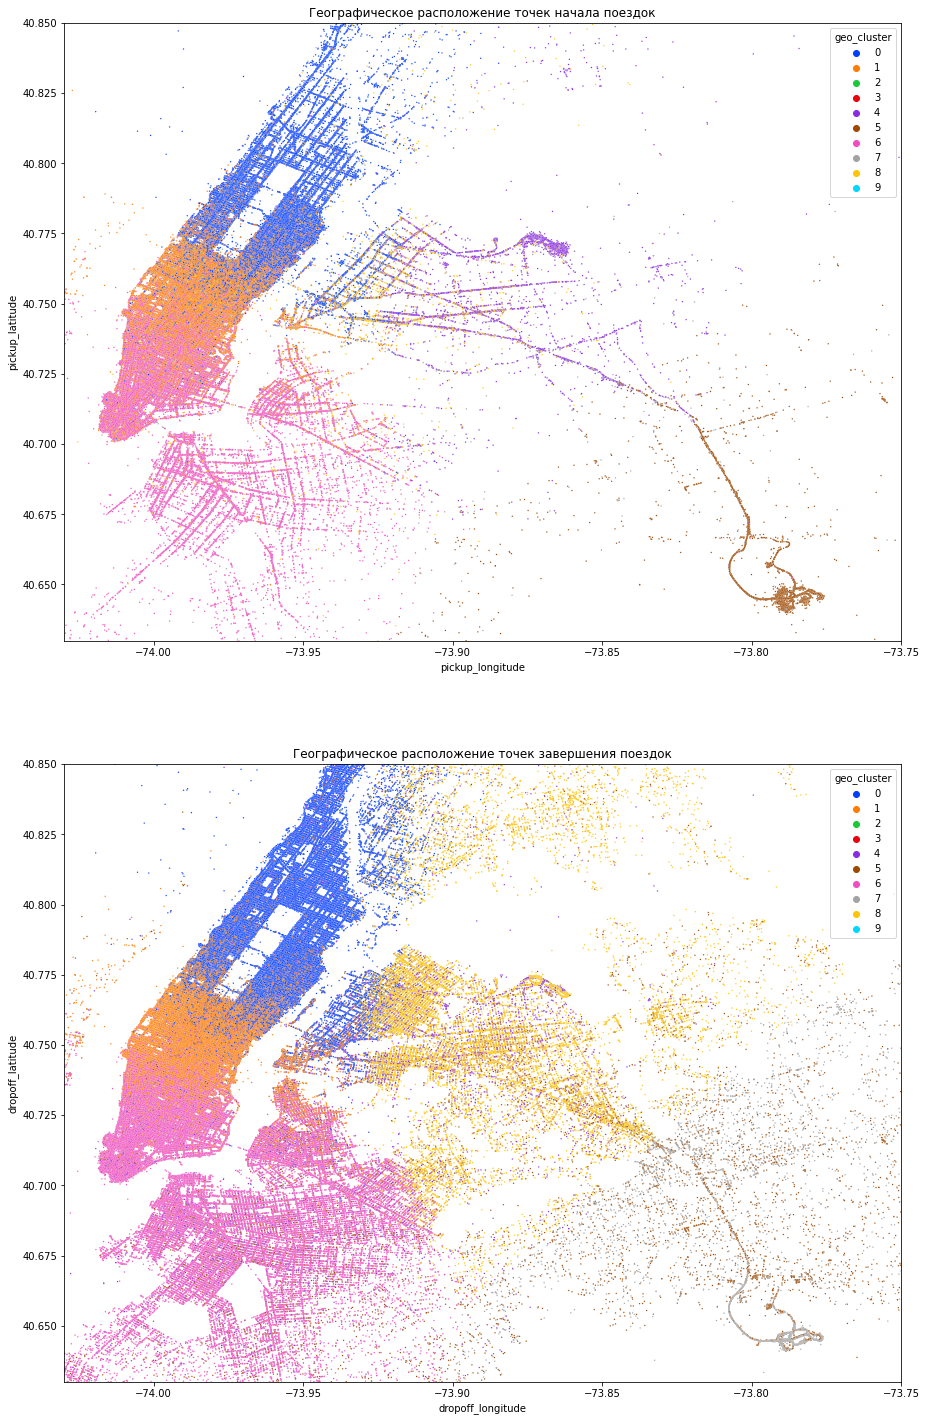

In [61]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 25))
pickup_scatter = sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    s=2,
    palette="bright",      
    ax=axes[0]
)
pickup_scatter.set_title('Географическое расположение точек начала поездок')
pickup_scatter.set(xlim=city_long_border, ylim=city_lat_border)

dropoff_scatter = sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude', 
    hue='geo_cluster',
    s=2,   
    palette="bright",
    ax=axes[1]    
)
dropoff_scatter.set_title('Географическое расположение точек завершения поездок')
dropoff_scatter.set(xlim=city_long_border, ylim=city_lat_border);

Из десяти кластеров не попало на диаграммы (находятся за границами Нью-Йорка) 2 кластера

In [62]:
cluster_duration_data = taxi_data.groupby('geo_cluster', as_index=False)['trip_duration'].median()

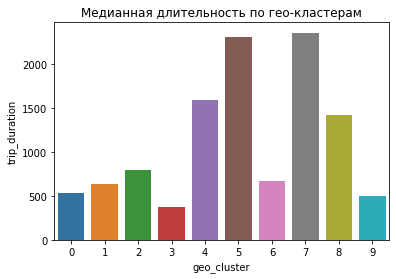

In [63]:
# Построим график зависимости длительности от точки старта
sns.barplot(data=cluster_duration_data,
            x='geo_cluster',
            y='trip_duration', 
            )

plt.title('Медианная длительность по гео-кластерам');

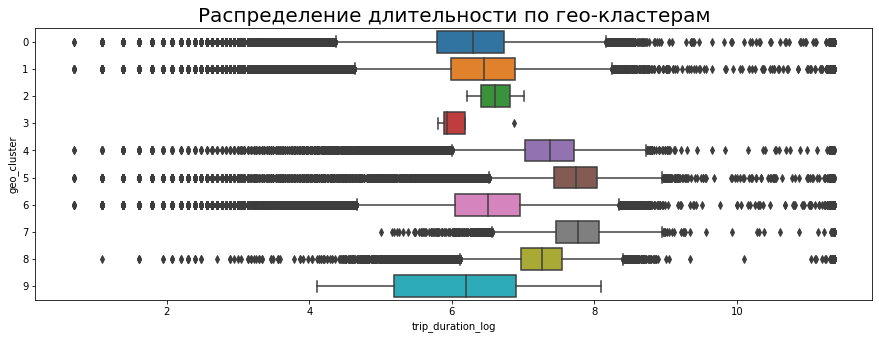

In [64]:
# Построим график зависимости длительности от точки старта
figure = plt.figure(figsize=(15, 5))
box = sns.boxplot(data=taxi_data,
            y='geo_cluster',
            x='trip_duration_log', 
            orient='h'
            )

plt.title('Распределение длительности по гео-кластерам', fontsize=20);

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [65]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [66]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности? - **id**

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных? - **dropoff_datetime**

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [67]:
train_data.drop(columns=['id', 'dropoff_datetime'], inplace=True)
train_data.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [68]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [69]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,0,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,1,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,1,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,1,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


In [70]:
print('Среднее по закодированному столбцу vendor_id = {:.2f}'.format(train_data['vendor_id'].mean()))

Среднее по закодированному столбцу vendor_id = 0.53


In [71]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)
train_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,6,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,1,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,2,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,5,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


In [72]:
print('Среднее по закодированному столбцу store_and_fwd_flag = {:.3f}'.format(train_data['store_and_fwd_flag'].mean()))

Среднее по закодированному столбцу store_and_fwd_flag = 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [73]:
# Столбцы для кодирования
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
# Объявляем кодировщик
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')
# Кодируем признаки
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
# Составляем DataFrame из закодированных признаков

data_onehot = pd.DataFrame(data_onehot, columns=column_names)


data_onehot.head()

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
print(f'Сгенерировано {data_onehot.shape[1]} бинарных столбцов с помощью однократного кодирования')

Сгенерировано 18 бинарных столбцов с помощью однократного кодирования


Добавим полученную таблицу с закодированными признаками:

In [75]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [76]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [77]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [78]:
# Создаем селектор для отбора
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)
# Производим отбор
selector.fit(X_train, y_train_log)

best_features_list = list(selector.get_feature_names_out())

best_features_list

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_hour',
 'pickup_holiday',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_1',
 'pickup_day_of_week_2',
 'pickup_day_of_week_3',
 'pickup_day_of_week_4',
 'pickup_day_of_week_5',
 'pickup_day_of_week_6',
 'geo_cluster_1',
 'geo_cluster_4',
 'geo_cluster_5',
 'geo_cluster_7',
 'geo_cluster_8']

In [79]:
X_train_cleared = X_train[best_features_list]
X_train_cleared.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_4,geo_cluster_5,geo_cluster_7,geo_cluster_8
293850,1,5,-73.958717,40.775002,-73.966599,40.773041,0,17,0,979.9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1144839,1,1,-73.958954,40.780697,-73.940643,40.805672,0,7,0,3177.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574433,1,1,-73.993469,40.747169,-74.002518,40.734200,0,11,0,1632.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
759223,1,1,-73.984970,40.753571,-74.011551,40.712910,0,15,0,7558.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429815,1,1,-73.956215,40.778744,-73.957932,40.776211,0,18,0,316.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X_valid_cleared = X_valid[best_features_list]
X_valid_cleared.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_4,geo_cluster_5,geo_cluster_7,geo_cluster_8
452652,0,1,-73.963493,40.757397,-73.953461,40.766804,0,11,0,1559.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
585387,0,2,-73.954185,40.781296,-73.954086,40.774498,0,21,0,1026.9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1226235,1,1,-73.927338,40.760990,-73.927338,40.760990,0,3,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
145996,0,1,-73.998512,40.760845,-73.980820,40.756828,0,12,0,1845.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
120104,1,1,-73.968323,40.763184,-73.979759,40.771114,0,17,0,1680.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [81]:
# Инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
# Обучаем нормализатор на обучающей выборке
scaler.fit(X_train_cleared)
# Преобразуем предикторы в обучающей и валидационной выборках
X_train_scaled = pd.DataFrame(scaler.transform(X_train_cleared), columns=best_features_list)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid_cleared), columns=best_features_list)

In [82]:
print('Среднее арифметическое для первого предиктора из валидационной выборки = {:.2f}'.format(X_valid_scaled.iloc[:, 0].mean()))

Среднее арифметическое для первого предиктора из валидационной выборки = 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [83]:
# Создаем модель линейной регрессии
lr_model = linear_model.LinearRegression()
# Обучаем модель на обучающей выборке
lr_model.fit(X_train_scaled, y_train_log)
# Делаем предсказания для обучающей и валидационной выборки
y_train_pred = lr_model.predict(X_train_scaled)
y_valid_pred = lr_model.predict(X_valid_scaled)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_pred, squared=False), 3))
print('RMSLE на валидационной выборке:', round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_pred, squared=False), 2))

RMSLE на тренировочной выборке: 0.534
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [84]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# Обучаем генератор
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной и валидационной выборки
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

In [85]:
X_valid_poly.shape

(481217, 350)

In [86]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
# Обучаем модель на тренировочной выборке
lr_model_poly.fit(X_train_poly, y_train_log)
# Делаем предсказание для тренировочной и валидационной выборки
y_train_poly_pred = lr_model_poly.predict(X_train_poly)
y_valid_poly_pred = lr_model_poly.predict(X_valid_poly)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', 
      round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_poly_pred, squared=False), 2))
print('RMSLE на валидационной выборке:', 
      round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_poly_pred, squared=False), 2))

RMSLE на тренировочной выборке: 0.47
RMSLE на валидационной выборке: 0.61


Наблюдаются признаки переобучения

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [87]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_poly = linear_model.Ridge(alpha=1) # коэф регуляризации ставим =1
# Обучаем модель на тренировочной выборке
ridge_poly.fit(X_train_poly, y_train_log)
# Делаем предсказание для тренировочной и валидационной выборки
y_train_ridge_pred = ridge_poly.predict(X_train_poly)
y_valid_ridge_pred = ridge_poly.predict(X_valid_poly)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', 
      round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_ridge_pred, squared=False), 2))
print('RMSLE на валидационной выборке:', 
      round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_ridge_pred, squared=False), 2))

RMSLE на тренировочной выборке: 0.48
RMSLE на валидационной выборке: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [88]:
# Создаём объект класса DecisionTreeRegressor
dt_reg = tree.DecisionTreeRegressor(random_state=42)
# Обучаем модель на тренировочной выборке
dt_reg.fit(X_train_scaled, y_train_log)
# Делаем предсказание для тренировочной и валидационной выборки
y_train_dt_pred = dt_reg.predict(X_train_scaled)
y_valid_dt_pred = dt_reg.predict(X_valid_scaled)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', 
      round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_dt_pred, squared=False), 2))
print('RMSLE на валидационной выборке:', 
      round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_dt_pred, squared=False), 2))


RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.56


Наблюдаются признаки переобучения модели

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [89]:
# Cоздаем списки для хранения метрик
rmsle_train = []
rmsle_valid = []
# Задаем диапазон глубины
max_depths = range(7, 20)
# Создаем цикл для расчета
for max_depth in max_depths:
    dt_reg_depth = tree.DecisionTreeRegressor(
        max_depth=max_depth,
        random_state=42
    )
    dt_reg_depth.fit(X_train_scaled, y_train_log)
    y_train_dt_depth_pred = dt_reg_depth.predict(X_train_scaled)
    y_valid_dt_depth_pred = dt_reg_depth.predict(X_valid_scaled)
    # Считаем метрики и добавляем их в списки
    rmsle_train.append(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_dt_depth_pred, squared=False))
    rmsle_valid.append(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_dt_depth_pred, squared=False))


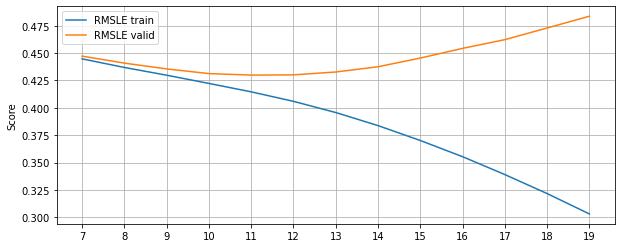

In [90]:
# Визуализируем метрики 
fix, ax = plt.subplots(figsize=(10, 4)) # фигура + координатная плоскость

# Строим линейный график зависимости метрик
ax.plot(max_depths, rmsle_train, label='RMSLE train')
ax.plot(max_depths, rmsle_valid, label='RMSLE valid')
plt.grid(which='major')
# Даем графику название и подписываем оси
ax.set_ylabel('Score')

# Устанавливаем отметки по оси х
ax.set_xticks(max_depths)

# Отображаем легенду
ax.legend();

На основании графика делаем заключение, что оптимальная глубина дерева = 12

In [91]:
# Создаём объект класса DecisionTreeRegressor
dt_reg_opt = tree.DecisionTreeRegressor(random_state=42, max_depth=12)
# Обучаем модель на тренировочной выборке
dt_reg_opt.fit(X_train_scaled, y_train_log)
# Делаем предсказание для тренировочной и валидационной выборки
y_train_dt_opt_pred = dt_reg_opt.predict(X_train_scaled)
y_valid_dt_opt_pred = dt_reg_opt.predict(X_valid_scaled)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', 
      round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_dt_opt_pred, squared=False), 2))
print('RMSLE на валидационной выборке:', 
      round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_dt_opt_pred, squared=False), 2))

RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [92]:
# Создаём объект класса RandomForestRegressor с запланированными параметрами
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42
)
# Обучаем модель на тренировочной выборке
rf.fit(X_train_scaled, y_train_log)
# Делаем предсказание для тренировочной и валидационной выборки
y_train_rf_pred = rf.predict(X_train_scaled)
y_valid_rf_pred = rf.predict(X_valid_scaled)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', 
      round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_rf_pred, squared=False), 2))
print('RMSLE на валидационной выборке:', 
      round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_rf_pred, squared=False), 2))


RMSLE на тренировочной выборке: 0.4
RMSLE на валидационной выборке: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [93]:
# Создаем объект класса градиентный бустинг с заданными параметрами
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100, 
    max_depth=6, 
    min_samples_split=30, 
    random_state=42,
    verbose=True
)
# Обучаем модель на тренировочной выборке
gb.fit(X_train_scaled, y_train_log)
# Делаем предсказание для тренировочной и валидационной выборки
y_train_gb_pred = gb.predict(X_train_scaled)
y_valid_gb_pred = gb.predict(X_valid_scaled)

# Расчитываем метрики
print('RMSLE на тренировочной выборке:', 
      round(metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_gb_pred, squared=False), 2))
print('RMSLE на валидационной выборке:', 
      round(metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_gb_pred, squared=False), 2))

      Iter       Train Loss   Remaining Time 
         1           0.3110           13.34m
         2           0.2247           13.01m
         3           0.1985           12.74m
         4           0.1873           12.56m
         5           0.1818           12.47m
         6           0.1783           12.30m
         7           0.1749           12.23m
         8           0.1718           12.12m
         9           0.1705           12.00m
        10           0.1693           11.83m
        20           0.1595           10.27m
        30           0.1540            8.91m
        40           0.1505            7.57m
        50           0.1475            6.28m
        60           0.1457            4.96m
        70           0.1433            3.67m
        80           0.1409            2.43m
        90           0.1393            1.20m
       100           0.1380            0.00s
RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


In [94]:
# Создаем датаффрейм для хранения всех результатов
results = pd.DataFrame(columns=['Model', 'RMSLE train', 'RMSLE valid'])
results['Model'] = ['Линейная регрессия', 'Полиномиальная регрессия второй степени', 
                    'Дерево решений', 'Случайный лес', 'Градиентный бустинг над деревьями решений']
results['RMSLE train'] = [metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_pred, squared=False), 
                          metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_poly_pred, squared=False), 
                          metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_dt_opt_pred, squared=False),
                          metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_rf_pred, squared=False),
                          metrics.mean_squared_error(y_true=y_train_log, y_pred=y_train_gb_pred, squared=False)]
results['RMSLE valid'] = [metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_pred, squared=False), 
                          metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_poly_pred, squared=False), 
                          metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_dt_opt_pred, squared=False),
                          metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_rf_pred, squared=False),
                          metrics.mean_squared_error(y_true=y_valid_log, y_pred=y_valid_gb_pred, squared=False)]
results.round(2)

,Model,RMSLE train,RMSLE valid
0,Линейная регрессия,0.53,0.54
1,Полиномиальная регрессия второй степени,0.47,0.61
2,Дерево решений,0.41,0.43
3,Случайный лес,0.40,0.41
4,Градиентный бустинг над деревьями решений,0.37,0.39


Наилучший результат показывает модель градиентного бустинга

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


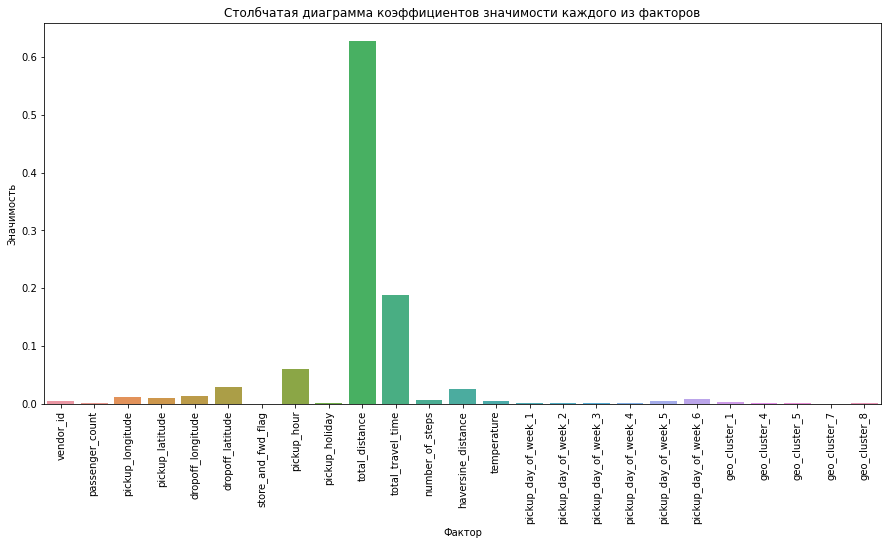

In [95]:
fig, ax = plt.subplots(figsize=(15, 7)) #фигура + координатная плоскость
feature = X_train_scaled.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax)
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Столбчатая диаграмма коэффициентов значимости каждого из факторов')
ax.set_xlabel('Фактор')
plt.xticks(rotation=90)
ax.set_ylabel('Значимость');

In [96]:
# Выводим важность признаков по убыванию
importance = pd.DataFrame(data=list(zip(feature, feature_importances)), columns=['feature', 'feature_importances'])
importance.sort_values(by='feature_importances', ascending=False)

,feature,feature_importances
9,total_distance,0.627660
10,total_travel_time,0.188583
7,pickup_hour,0.059535
5,dropoff_latitude,0.027807
12,haversine_distance,0.025779
4,dropoff_longitude,0.012840
2,pickup_longitude,0.011489
3,pickup_latitude,0.010367
19,pickup_day_of_week_6,0.007353
11,number_of_steps,0.005590


### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [97]:
# Переводим целевую переменную и полученное предсказание для валидационной выборки 
# модели градиентный бустинг из логирифмического масштаба в изначальный
y_valid_gb_pred_exp = np.exp(y_valid_gb_pred) - 1
y_valid = np.exp(y_valid_log)

# Рассчитываем медианную абсолютную ошибку на валидационной выборке
meae = metrics.median_absolute_error(y_true=y_valid, y_pred=y_valid_gb_pred_exp)
print('MeAE на валидационной выборке: {:.1f} мин'.format(meae/60))

MeAE на валидационной выборке: 1.8 мин


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [98]:
test_data = pd.read_csv("Data/test_data.csv")
osrm_data_test = pd.read_csv("Data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [99]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data, 'pickup_datetime')
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features_list]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [100]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=best_features_list)
X_test_scaled.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_4,geo_cluster_5,geo_cluster_7,geo_cluster_8
0,0.0,0.142857,0.791203,0.636454,0.791169,0.731039,0.0,1.0,0.0,0.043147,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.142857,0.791598,0.631256,0.791671,0.722405,0.0,1.0,0.0,0.033015,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.142857,0.791050,0.637009,0.791236,0.728724,0.0,1.0,0.0,0.017044,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.142857,0.791732,0.640436,0.791231,0.728804,0.0,1.0,0.0,0.079839,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.142857,0.791499,0.639395,0.791642,0.730971,0.0,1.0,0.0,0.012597,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [101]:
# Предсказание длительности поездки для тестовой выборки
y_test_predict = np.exp(gb.predict(X_test_scaled)) - 1

# Код для создания submission-файла:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('Data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [102]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features_list)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features_list)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features_list)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [103]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74193
[10]	train-rmse:0.49088	valid-rmse:0.49348
[20]	train-rmse:0.44044	valid-rmse:0.44330
[30]	train-rmse:0.42617	valid-rmse:0.42916
[40]	train-rmse:0.41819	valid-rmse:0.42137
[50]	train-rmse:0.41244	valid-rmse:0.41596
[60]	train-rmse:0.40896	valid-rmse:0.41286
[70]	train-rmse:0.40616	valid-rmse:0.41034
[80]	train-rmse:0.40337	valid-rmse:0.40784
[90]	train-rmse:0.40131	valid-rmse:0.40613
[100]	train-rmse:0.39957	valid-rmse:0.40474
[110]	train-rmse:0.39810	valid-rmse:0.40348
[120]	train-rmse:0.39658	valid-rmse:0.40223
[130]	train-rmse:0.39522	valid-rmse:0.40118
[140]	train-rmse:0.39453	valid-rmse:0.40075
[150]	train-rmse:0.39374	valid-rmse:0.40021
[160]	train-rmse:0.39248	valid-rmse:0.39923
[170]	train-rmse:0.39159	valid-rmse:0.39859
[180]	train-rmse:0.39081	valid-rmse:0.39809
[190]	train-rmse:0.39009	valid-rmse:0.39770
[200]	train-rmse:0.38936	valid-rmse:0.39730
[210]	train-rmse:0.38872	valid-rmse:0.39690
[220]	train-rmse:0.38809	valid-rmse:0.39651

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [104]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39415


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

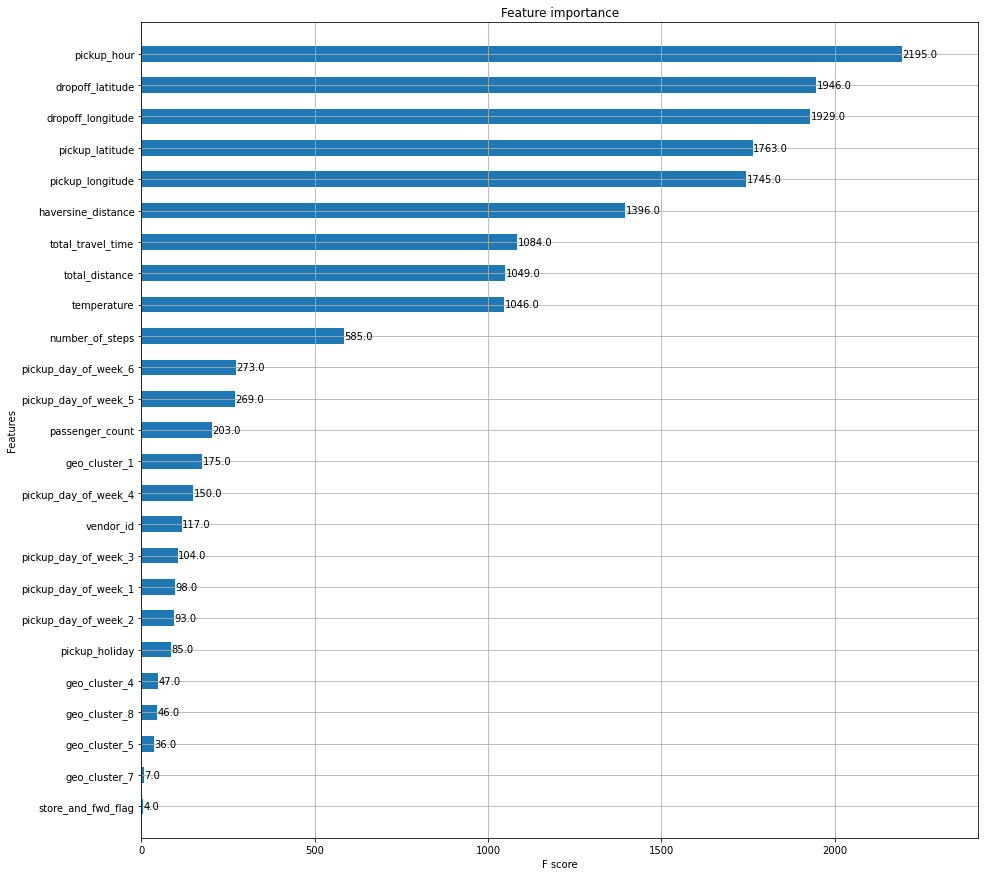

In [105]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)